In [1]:
import sys, os
os.chdir('G:\My Drive\Documents\PhD\Modelling\_RiceBall')

In [2]:
import ricepaper
import ricepaper.postprocess as pp
from ricepaper import RicePaper
from ricepaper.reader import RiceBall
from ricepaper.dykes import DykeFarm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [3]:
R = RicePaper("Volcano_SSR")

The following sets up the basic material and numerical properties for our DEM and static boundaries for the volcano to sit on

In [4]:
#setup simulation as per La Palma demo
#material properties
resolutionFactor=1 #ball radii is divided by this, number of balls created multiplied by this
tsFactor=2 #ts is divided by this, number of steps multiplied by this
R.setRadius(1,30/resolutionFactor)  #radius 1 (volcano)
R.setRadius(2,25/resolutionFactor)  #radius 2 (volcano)
R.setRadius(3,20/resolutionFactor)  #boundary radius

R.setDensity(1,2500) #all 2500
R.setDensity(2,2500) 
R.setDensity(3,2500) 

R.setHertzian(1,2.9e9,0.2) #volcano type
R.setHertzian(2,2.9e9,0.2) #dyke type
R.setHertzian(3,2.9e9,0.2) #boundary type

#set cohesion between edifice and base particles
R.custom("COH 0.4 1 3")

In [5]:
R.setLinItc(1,1,2e10,2e10)
R.setLinItc(1,2,2e10,2e10)
R.setLinItc(1,3,2e10,2e10)
R.setLinItc(2,2,2e10,2e10)
R.setLinItc(2,3,2e10,2e10)
R.setLinItc(3,3,2e10,2e10)

R.setFrictionItc(1,1,0.2)
R.setFrictionItc(1,2,0.2)
R.setFrictionItc(1,3,0.2)
R.setFrictionItc(2,2,0.4) #dykes have higher friction angle 
R.setFrictionItc(2,3,0.2)
R.setFrictionItc(3,3,0.2)

In [6]:
#numerical properties
R.setDamping() #use defaults
R.setNumericalProperties(timestep=5e-2 / tsFactor)

#generate line of balls
R.genLine((25, 75, 50),(25, 4975, 50), 10, 3, 3) #left side
R.genLine((14975, 75, 50),(14975, 4975, 50), 10, 3, 3) #righth side
R.genLine((25, 25, 50),(14975, 25, 50), 10, 3, 3) #bottom side
R.fixDOFAll(True,True,True) #fix DOF on balls


R.setGravity((0,-9.8,0)) #set gravity

Next, we generate sets of balls which we let settle progressively to produce a gravitationally consolidated/settled pile. This provides the "starting material" for our edifice.

In [7]:
#create balls and cycle
activeColor = 'g'
altColor = 'b'
for i in range(6):
    R.setDomain(5000,10000,3500,6500,0,100) #domain to create balls in
    
    R.genBalls(250*resolutionFactor,1,1,color=activeColor)
    R.genBalls(500*resolutionFactor,2,1,color=activeColor)
    
    #fix rotation from this point onwards (to increase the internal angle of friction)
    R.setDomain(4999,10001,3499,6501,0,100)
    R.custom("PRP 1 FIX 0 0 0 1 1 1")

    R.cycle(2000*tsFactor)
    
    #flip color
    tmp = activeColor
    activeColor = altColor
    altColor = tmp
R.cycle(4000*tsFactor,createFig=True) #final cycle to let any other balls settle
R.cycle(4000*tsFactor,createFig=True)
R.cycle(4000*tsFactor,createFig=True)
R.cycle(4000*tsFactor,createFig=True)

10

In [8]:
#let these gravitationally settle to provide the starting material for our volcano
R.execute(suppress=True) #set supress = True if results have already been calculated and we just want to re-load

0

Step010.bnd
loading bfile


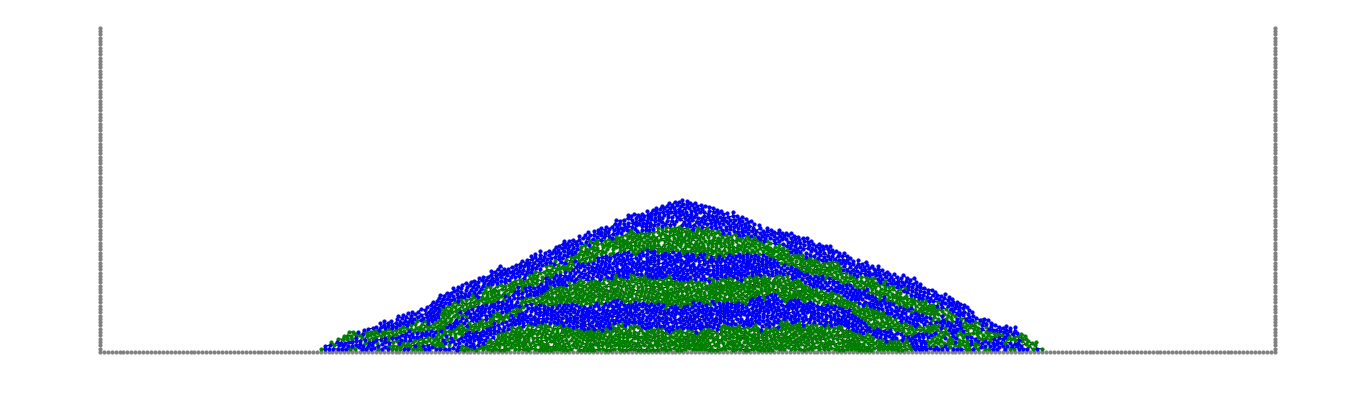

In [9]:
#quickly inspect
model = R.loadLastOutput()
model.quickPlot()

To get the desired volcano shape, we trim the edifice using cutting lines to give it a specific slope.

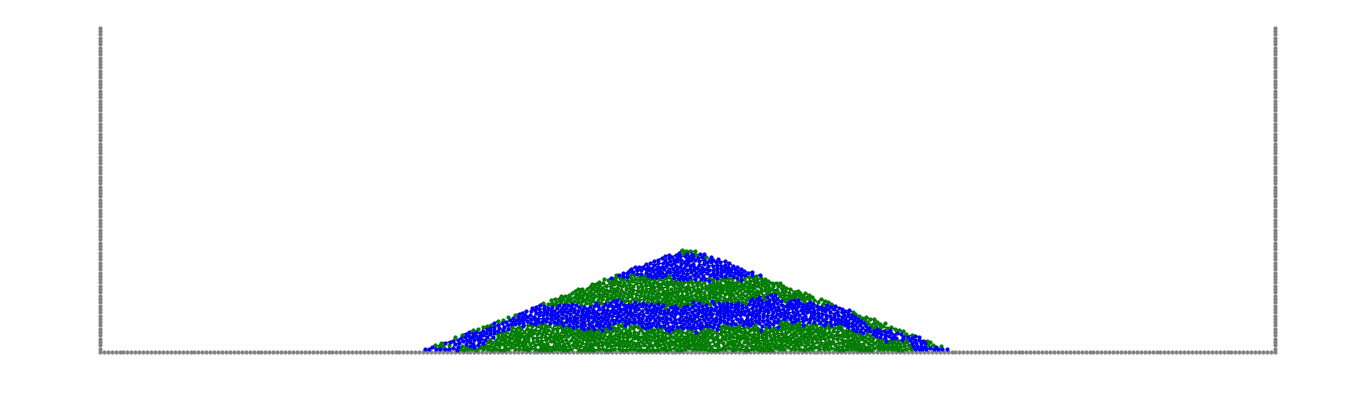

In [10]:
#shape volcano using cutting lines
deleted = []
deleted = model.cut(4000,25) #25 degree slope
deleted += model.cut(11000,-25)
model.quickPlot()

In [11]:
#delete balls from model
R.delBalls(deleted,model.pos)

#turn off damping
R.setDamping(None,None)

Now things get a little more complicated. We "clone" the above model into two different forks - one in which we change nothing and simply let the edifice re-equilibrate (the "control" case), and the other in which we create a bunch of "strong" dykes before letting everything settle. These dykes are expected to change the stress distribution and strength of the bulk edifice, and hence change the stability and the associated evolution.

In [12]:
#dump output so we can reproduce model to this state without stochastic functions
R.dumpState("Volcano_SSR/trubalw_no_stochastic.dat")

#clone model to create control set and dyke set
R_ctrl = R.clone("Volcano_SSR/Control")
R_dyke = R.clone("Volcano_SSR/Dykes")

Step010.bnd
loading bfile


We set up the dyke network by randomly selecting dyke locations and orientations (from the specified normal distributions) and then propagating "paths" as close to this orientation as possible through the edifice. To simulate dyke arrest, there is a certain probability of dyke arrest per propagation step.

In [13]:
#calculate dyke particles for dyke model
meanx = 7000
stdvx = 1000

meand = 90
stdvd = 20

np.random.seed(3)

#create dykes
dykes = []
bonds = []
farm = DykeFarm(model,p_arrest=0.015)
for i in range(50):
    #sample random position and ori
    pos = np.random.normal(meanx,stdvx)
    dip = np.random.normal(meand,stdvd)
    if dip > 90: #map dips > 90 to negative dips
        dip = dip - 180
        
    #make dyke
    dyke,bond = farm.dykeFromOri(pos,dip,useCost=False)
    dykes += dyke #store nodes
    bonds += bond #store bonds


In [14]:
#compute bond strength properties


#n.b.
#rock properties for (intact) basalt as per https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JE00691
#E = 70 Gpa (scales to deformation modulus of 5-50 Mpa -i.e. drop one order of magnitude)
#v = 0.25
#TS = 10 MPa -- tensile strength
#UCS = 250 MPa
#fric coeff = 0.6
#cohesion = 60 MPa  -- "sstrength represents the cohesive strength at zero normal stress"

"""
Function for calculating the bond-strength resulting from a dyke with specified strength and thickness.

**Arguments**:
-E = the Young's modulus of the dyke (Pascals)
-v = the Poisson's ratio of the dyke
-Ts = the tensile strength of the dyke (Pascals)
-Ss = the shear strength of the dykek (Pascals)
-t = the thickness of the dyke
-r = the smaller radius of the sphere's being bonded
-sf = scaling factor to account for rock-mass scale effects. Strength and elastic properties are multiplied by this value. 
     Default is 0.1 (10%).
**Returns**:
-Scaled Young's modulus, Shear modulus, Tensile strength and Shear strength.
"""
def calcDykeBondStrength(E,v,Ts,Ss,t,r,sf=0.1):
    #compute contact and dyke areas
    A_contact = np.pi * r**2 #total area of contact
    theta = 2 * np.arcsin(t/(2*r))
    A_dyke = theta * r ** 2 + r * t * np.cos(theta) #area of segment representing dyke
    A_ratio = A_dyke / A_contact #fraction of total area represented by dyke. We scale the mech properties by this.
    
    #compute shear modulus from E and v
    G = E / (2 + 2*v)
    
    return E * A_ratio, G * A_ratio, Ts * A_ratio, Ss * A_ratio

#strenght properties for 1-m thick dykes
E,G,Ts,Ss = calcDykeBondStrength(70e9,0.25,10e6,60e6,1,25/resolutionFactor,0.1) #n.b. we reduce strength by 1 order of magnituded to account for scale

In [15]:
#assign dykes to model
for n in dykes:
    R_dyke.setDomainToPos(model.pos[n]) #select node
    R_dyke.custom("PRP 1 COL x 3") #change dyke color to red
    R_dyke.custom("PRP 1 SURf x 2 ") #change surface type to 2 (dyke)

#define bond properties 
R_dyke.custom("BONd %.2E %.2E %.2E %.2E 2 2" % (E,G,Ts,Ss))

#make bonds between dyke-particles
for n1,n2 in bonds:
    e = 1 #fudge factor to ensure particle centres are within domain
    minx = min( model.pos[n1][0] - e, model.pos[n2][0] - e)
    maxx = max( model.pos[n1][0] + e, model.pos[n2][0] + e)
    miny = min( model.pos[n1][1] - e, model.pos[n2][1] - e)
    maxy = min( model.pos[n1][1] + e, model.pos[n2][1] + e)
    R_dyke.custom("DOB %d %d %d %d 0 100\n" % (minx,maxx,miny,maxy)) #set bonding domain to just contain these two particles
    R_dyke.custom("MKBonds %f 2 2" % (max(model.radii.values()) * 2 + 1))  #make bond

#domain = model.getBounds(dynamic=False)
#R_dyke.custom("DOB %d %d %d %d 0 100" % domain) #set bounds for bonding to entire model domain
#rmax = max(model.radii.values())
#R_dyke.custom("MKBonds %f 2 2" % (rmax * 2 + 1))  #TODO - avoid cross-dyke bonding...

Now we add the necessary number of cycles/output calls to watch as the two different volcanoes restabilise.

In [16]:
#calculate and plot as models re-stabilises
outFiles = [] #keep track of expected output files
queue = [] #list of models to run
for i,R in enumerate([R_ctrl,R_dyke]):
    
    #set timestep
    R.setNumericalProperties(timestep=2e-2/tsFactor)

    #let model re-equilibrate after load reduction (note that this *should* be stable & hence static)
    R.cycle(5000)

    #destabilise
    #R.custom("COH 0.0 1 3") #remove basal cohesion
    #R.setGravity((0,-12,0)) #set gravity
    
    #slowly reduce the shear strength of the model
    #Dyke strength is 1E7 1E7 5E3 5E3 2 2
    #Host strength is 5E6 5E6 2.5E3 2.5E3 1 1

    SS = [0.2,0.14,0.13]#np.linspace(0.2,0.1,6)
    #hbSS = np.linspace(2.5e3,5e2)
    #dbSS = np.linspace(5e3,1e3)*0.001
    for n,ss in enumerate(SS): #5 different shear strenghts
        #build model suite for this shear strength
        Rc = R.clone(os.path.join(R.dir,"SS_%.2f"%ss))

        #set internal friction for this model
        Rc.setFrictionItc(1,1,ss)
        
        #Rc.custom("BONd 5E6 5E6 %d %d 1 1" % (dbSS[n],dbSS[n]))
        #Rc.custom("BONd 5E6 5E6 %d %d 1 1" % (dbSS[n],dbSS[n]))
        #R.custom("MKBonds 61 1 1") 
        #R.custom("MKBonds 61 2 2") 
        
        #run model in steps as it re-equilibrates
        out = []
        for step in range(10): #output every 1000 steps as model restabilises after reducing shear strength
            out.append(Rc.cycle(1000 * tsFactor,createFig=True))
        
        #queue model
        outFiles.append(out)
        queue.append(Rc)
        #todo - write smart code to decide if model has failed?

#crunch models (control and the model with dykes are run in separate threads)
ricepaper.multiThreadExecute(queue,suppress=True)

Launching job 1 of 6.
Launching job 2 of 6.
Launching job 3 of 6.
Launching job 4 of 6.
Launching job 5 of 6.
Launching job 6 of 6.


In [30]:
model = queue[5].loadSteps(11)

Step011.bnd
loading bfile


In [31]:
model.brk

[['Tensile Failure',
  '56001',
  '24121',
  '31111',
  '2',
  '2',
  '0.2500E+02',
  '0.2500E+02',
  '0.7424E+04',
  '0.5937E+02',
  '0.5000E+02',
  '0.7373E+04',
  '0.5921E+02',
  '0.5000E+02',
  '-0.1687E+11',
  '-0.0000E+00',
  '-0.5007E+09\n'],
 ['Tensile Failure',
  '56001',
  '18241',
  '21811',
  '2',
  '2',
  '0.3000E+02',
  '0.3000E+02',
  '0.6939E+04',
  '0.3180E+03',
  '0.5000E+02',
  '0.6878E+04',
  '0.3162E+03',
  '0.5000E+02',
  '-0.6863E+11',
  '-0.0000E+00',
  '-0.7210E+09\n'],
 ['Tensile Failure',
  '56001',
  '20761',
  '33601',
  '2',
  '2',
  '0.3000E+02',
  '0.2500E+02',
  '0.7671E+04',
  '0.3337E+03',
  '0.5000E+02',
  '0.7728E+04',
  '0.3329E+03',
  '0.5000E+02',
  '-0.1436E+12',
  '-0.0000E+00',
  '-0.5007E+09\n'],
 ['Shear Failure',
  '56045',
  '59941',
  '79411',
  '2',
  '2',
  '0.3000E+02',
  '0.2500E+02',
  '0.6253E+04',
  '0.8174E+03',
  '0.5000E+02',
  '0.6199E+04',
  '0.8196E+03',
  '0.5000E+02',
  '0.1777E+11',
  '0.1038E+11',
  '0.1011E+11\n'],
 ['Te

In [ ]:
assert False

Step012.bnd
loading bfile
Step013.bnd
loading bfile
Step014.bnd
loading bfile
Step015.bnd
loading bfile
Step016.bnd
loading bfile
Step017.bnd
loading bfile
Step018.bnd
loading bfile
Step019.bnd
loading bfile
Step020.bnd
loading bfile
Step021.bnd
loading bfile


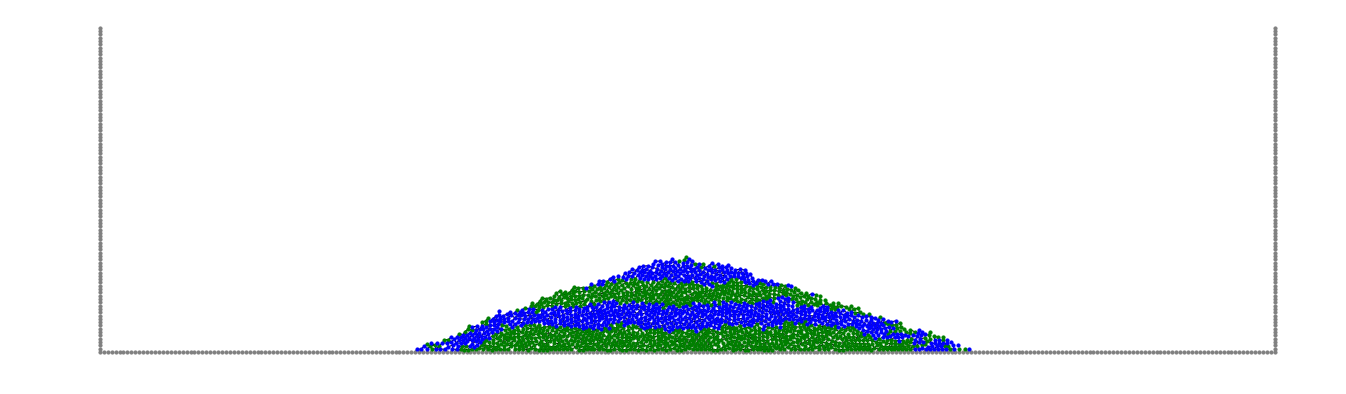

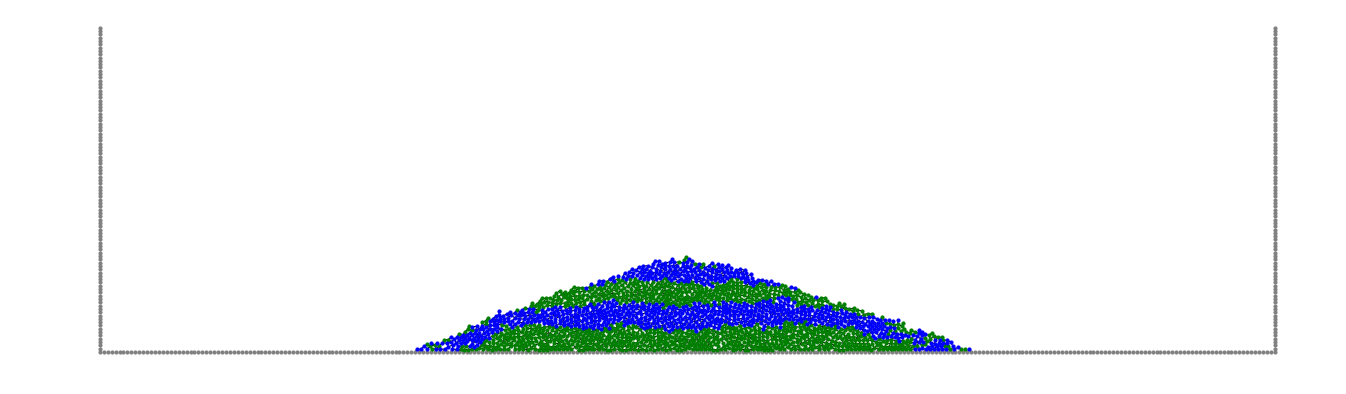

Step012.bnd
loading bfile
Step013.bnd
loading bfile
Step014.bnd
loading bfile
Step015.bnd
loading bfile
Step016.bnd
loading bfile
Step017.bnd
loading bfile
Step018.bnd
loading bfile
Step019.bnd
loading bfile
Step020.bnd
loading bfile
Step021.bnd
loading bfile


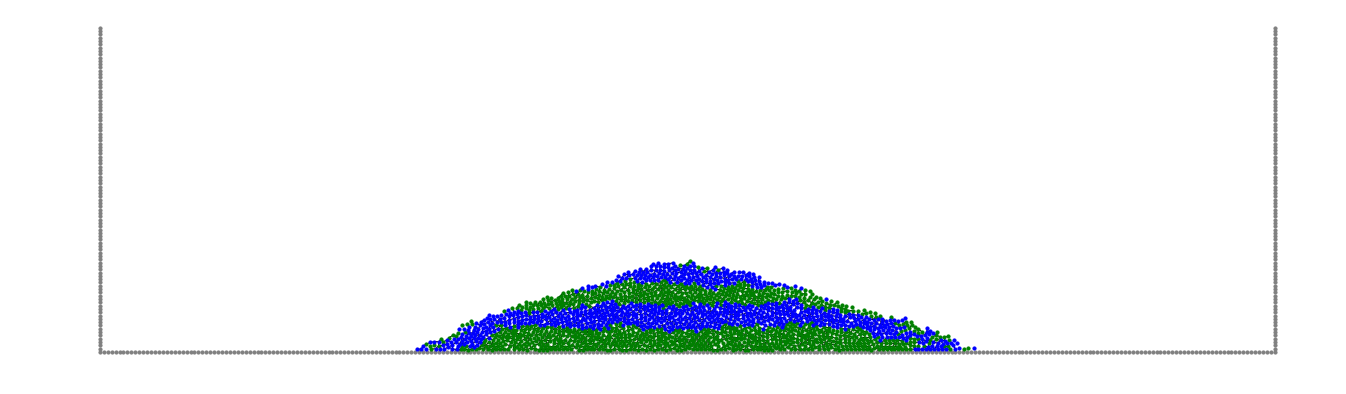

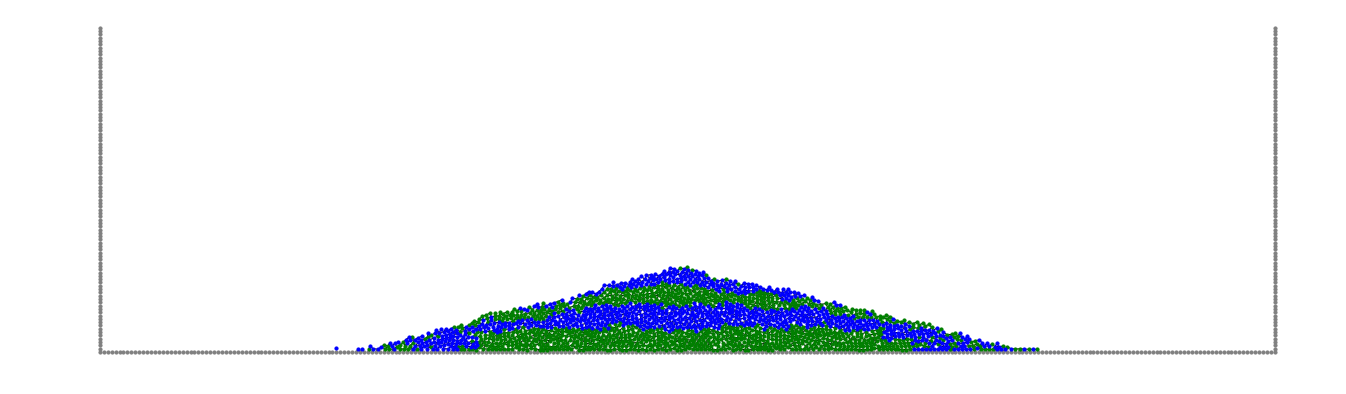

Step012.bnd
loading bfile
Step013.bnd
loading bfile
Step014.bnd
loading bfile
Step015.bnd
loading bfile
Step016.bnd
loading bfile
Step017.bnd
loading bfile
Step018.bnd
loading bfile
Step019.bnd
loading bfile
Step020.bnd
loading bfile
Step021.bnd
loading bfile


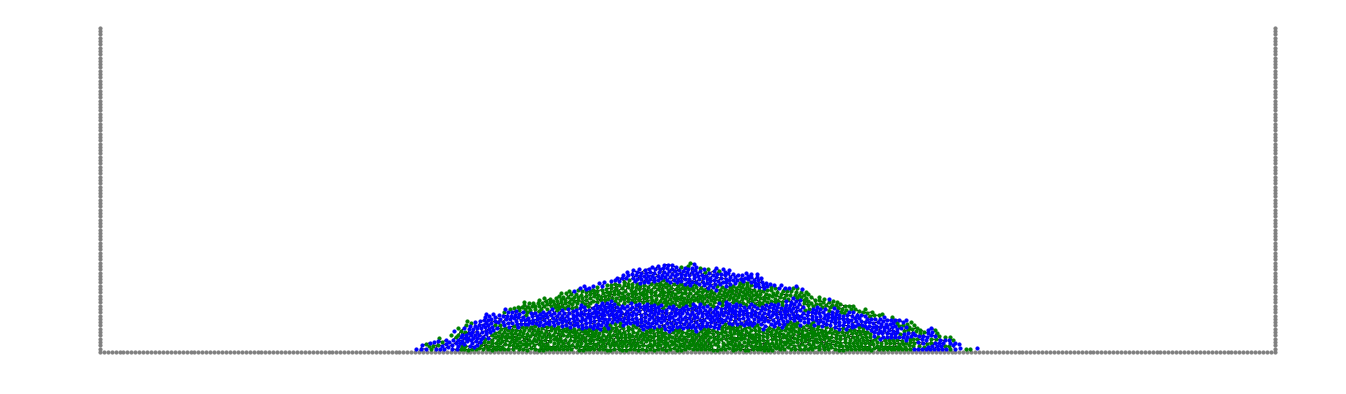

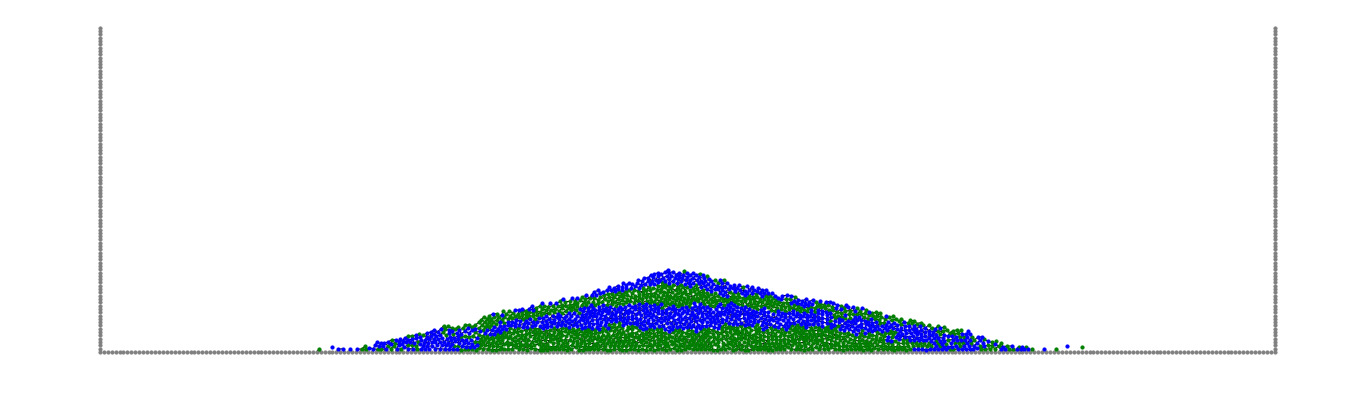

Step012.bnd
loading bfile
Step013.bnd
loading bfile
Step014.bnd
loading bfile
Step015.bnd
loading bfile
Step016.bnd
loading bfile
Step017.bnd
loading bfile
Step018.bnd
loading bfile
Step019.bnd
loading bfile
Step020.bnd
loading bfile
Step021.bnd
loading bfile


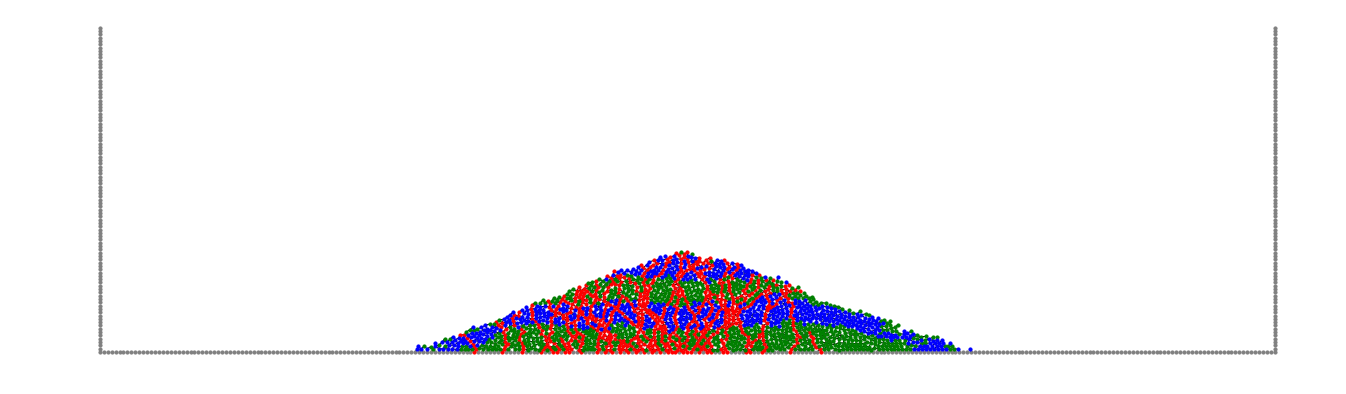

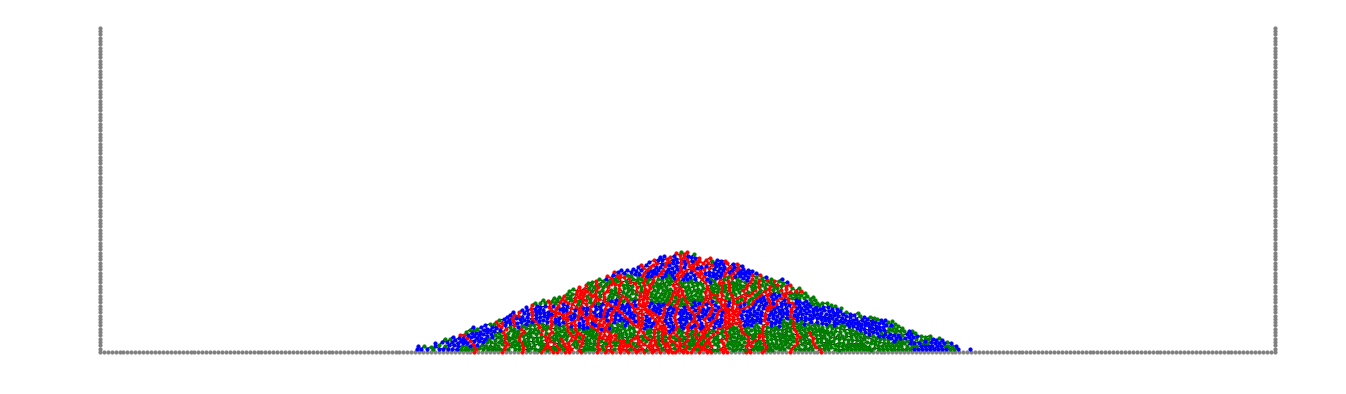

Step012.bnd
loading bfile
Step013.bnd
loading bfile
Step014.bnd
loading bfile
Step015.bnd
loading bfile
Step016.bnd
loading bfile
Step017.bnd
loading bfile
Step018.bnd
loading bfile
Step019.bnd
loading bfile
Step020.bnd
loading bfile
Step021.bnd
loading bfile


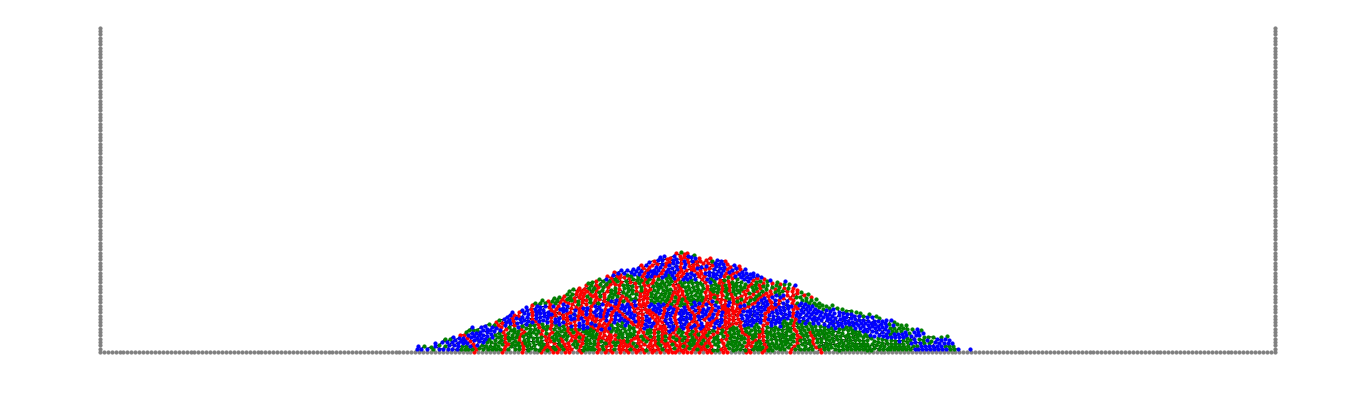

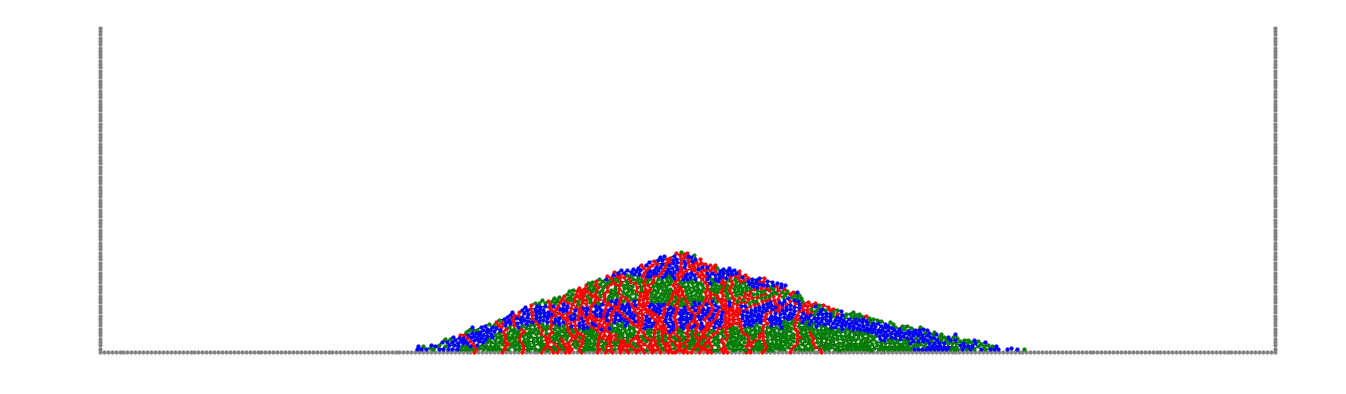

Step012.bnd
loading bfile
Step013.bnd
loading bfile
Step014.bnd
loading bfile
Step015.bnd
loading bfile
Step016.bnd
loading bfile
Step017.bnd
loading bfile
Step018.bnd
loading bfile
Step019.bnd
loading bfile
Step020.bnd
loading bfile
Step021.bnd
loading bfile


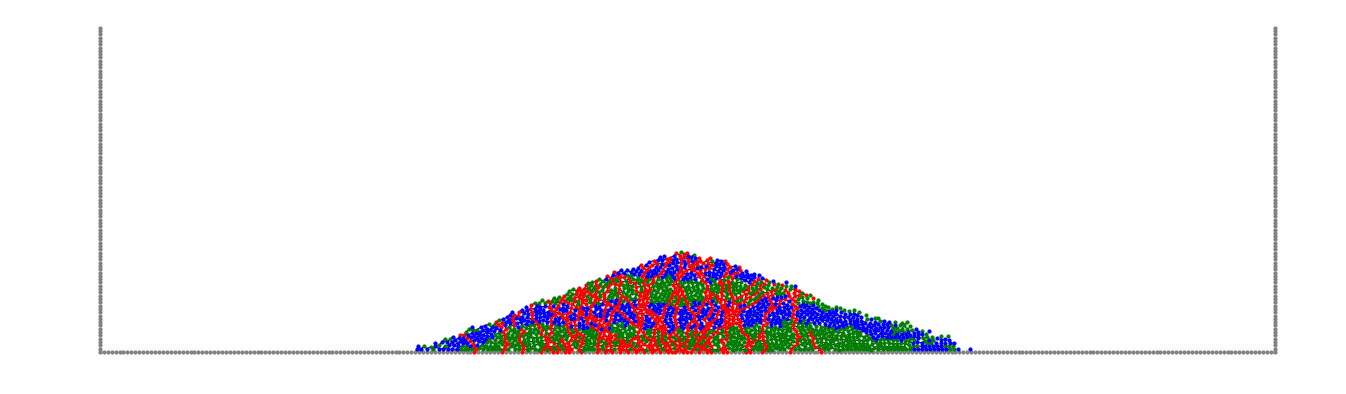

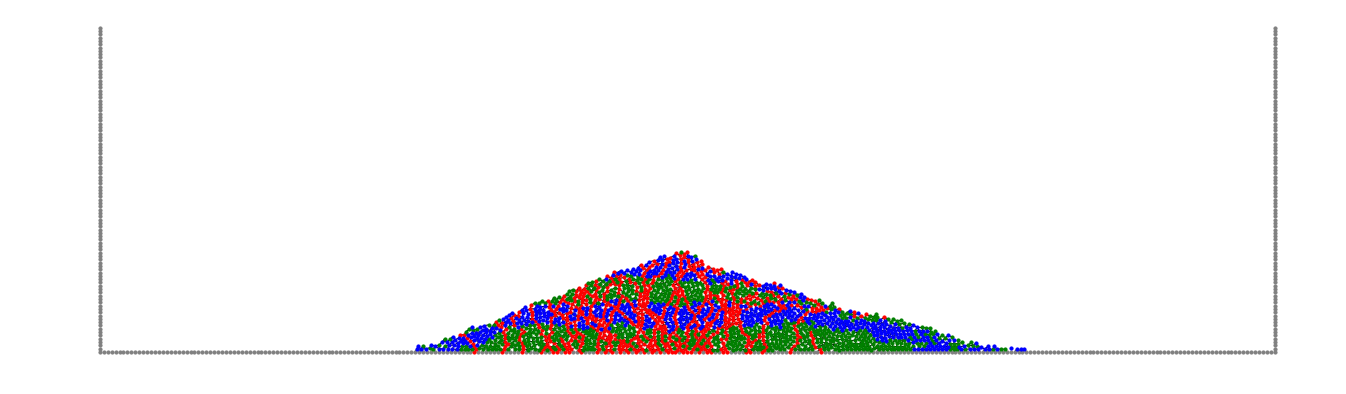

In [17]:
#load the results
results = []
for i,R in enumerate(queue):
    #load steps
    steps = R.loadSteps(outFiles[i])
    
    #build vtk output directory
    vtkPath = os.path.join(R.dir,"vtk")
    if not os.path.exists(vtkPath):
            os.makedirs(os.path.join(R.dir,"vtk"))
    
    #export to vtk
    #for n,m in enumerate(steps[1:]):
        #m.computeParticleStresses()
        #m.computeParticleDisplacements(steps[n])
        #m.writeVTK(os.path.join(vtkPath,"STEP_%03d" % outFiles[i][n+1]))
        
    #quickly plot first and last model
    steps[0].quickPlot()
    steps[-1].quickPlot()
    
    #store
    results.append(steps)

Now that we have loaded the model we can postprosses them to look at differences in stress state, strain localisation, stable slope angle etc.

In [18]:
def postProcess(models,dx=100):
    dy = dx #is a square grid so dy = dx, but using dx everywhere makes the calculus confusing
    for i,m in enumerate(models[1:]):
        m.computeParticleStresses()
        m.computeParticleDisplacements(models[i-1]) #compare with previous model
        
        #grid velocity components
        Vx,Vy = pp.gridModel( m, ["UDOT.x","UDOT.y"], dx)
        
        #plot speed
        pp.quickPlot(np.sqrt(Vx**2 + Vy**2),cmap="viridis")
        
        #"speed" gradient
        if True:       
            V_norm = np.sqrt(Vx**2 + Vy**2) #create grid of velocity magnitude
            grad = np.dstack(np.gradient(V_norm,dx))
            grad = np.linalg.norm(grad,axis=2)
            pp.quickPlot(grad,cmap="viridis")
        
        #velocity gradient
        if False:
            vxx, vxy = np.gradient(Vx,dx)
            vyx, vyy = np.gradient(Vy,dy)
            L = np.array([[vxx,vxy],[vyx,vyy]])

            #split deformation and rotational components:

            #rate of deformation tensor
            Dxx = vxx
            Dxy = 1/2. * (vxy + vyx)
            Dyx = Dxy
            Dyy = vyy

            #spin tensor
            Lxx = 0
            Lxy = 1/2. * (vxy - vyx)
            Lyx = 1/2. * (vyx - vxy)
            Lyy = 0
        
        
            #extract "rate of expansion" and "rate of shear" scalars from the rate of deformation tensor
            J = 1/2. * (Dxx + Dyy) #expansion term
            S = Dxy #shear term

            #plot
            pp.quickPlot(J,cmap="viridis")
            pp.quickPlot(np.abs(S),cmap="viridis")

        #strain tensor
        if True:
            #grid displacement vectors
            ux,uy = pp.gridModel( m, "disp", dx) 
            
            #plot displacement field
            pp.quickPlotV(np.dstack([ux,uy]),cmap="viridis",normed=False,scale=1e4,headwidth=0)
            
            #compute deformation gradient tensor
            Fxx,Fxy = np.gradient(ux,dx)
            Fyx,Fyy = np.gradient(uy,dy)
            
            #compute greens strain tensor
            Sxx = Fxx - 1
            Sxy = 1/2. * (Fxy + Fyx) 
            Syx = Sxy
            Syy = Fyy - 1
            
            #calculate strain invariants
            shear_strain = Sxy + Syx
            dilation  = 1/2. * (Sxx + Syy) + 1
            
            #get min/max for plotting
            maxss = 5#np.nanmax(np.abs(shear_strain))
            maxdl = 1#np.nanmax(np.abs(dilation))
            
            pp.quickPlot(shear_strain,cmap="RdBu",clim=(-maxss,maxss),)
            pp.quickPlot(dilation,cmap="RdBu",clim=(-maxdl,maxdl))

        if False:
            #plot differential stress and sig1 trajectories
            dif = pp.gridModel( m,"dif",dx)
            sig1 = np.dstack(pp.gridModel( m,"sigma1",dx))
            pp.quickPlotV(sig1,cmap="viridis",scale=30,headwidth=0,color="k")
            pp.quickPlot(dif, cmap="viridis")

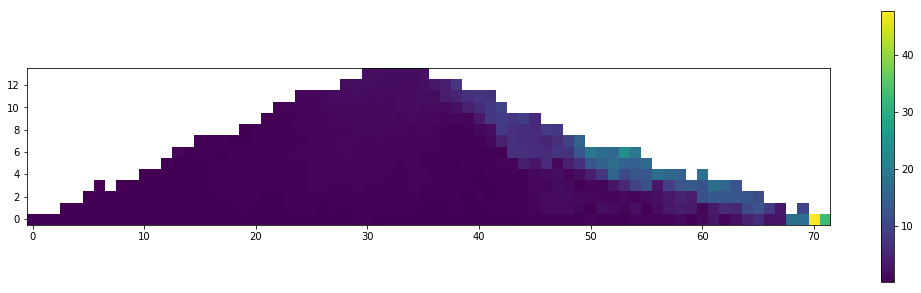

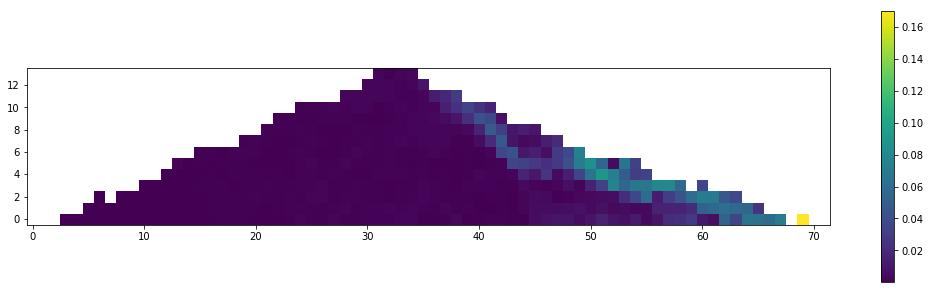

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


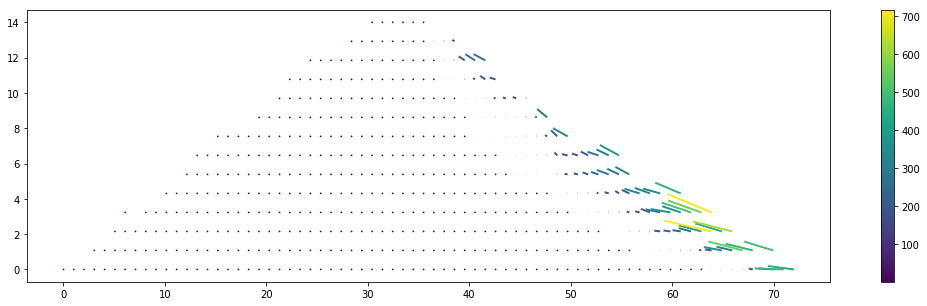

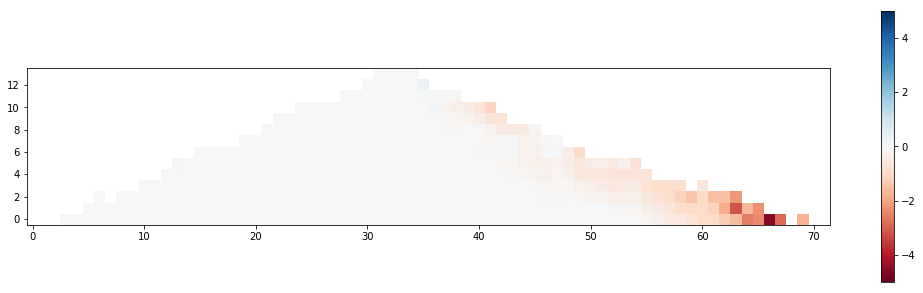

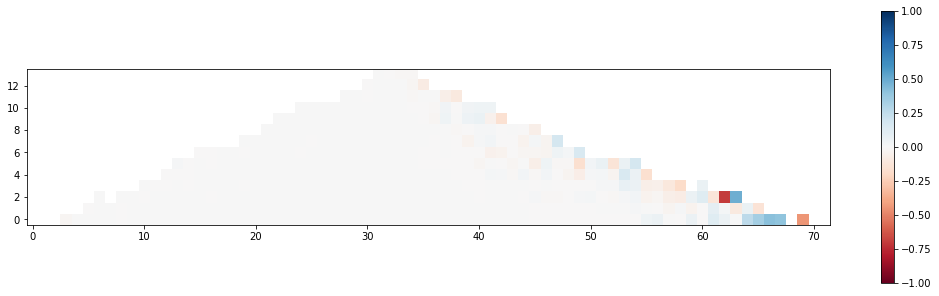

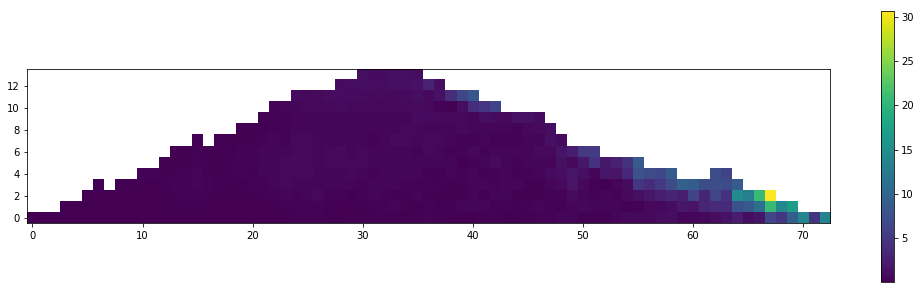

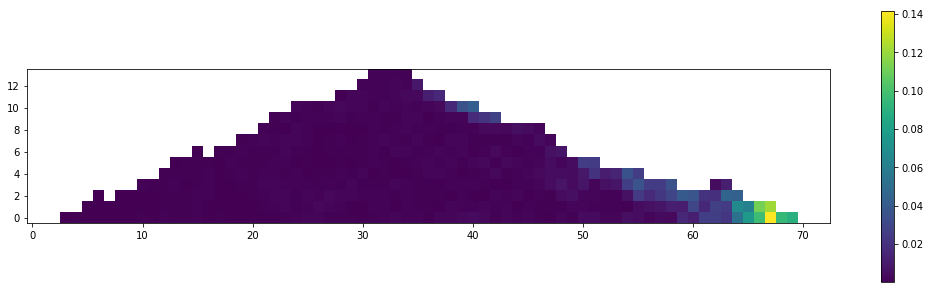

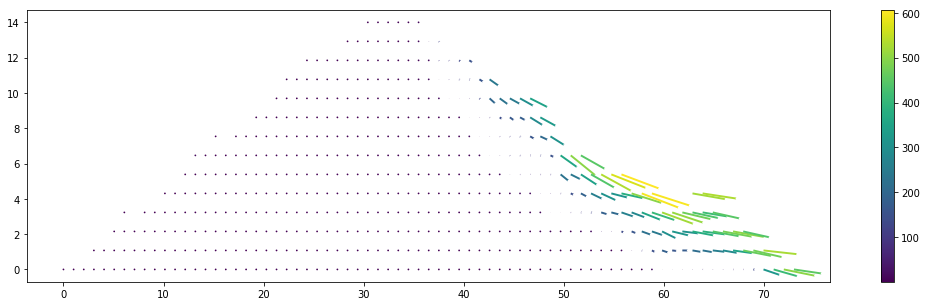

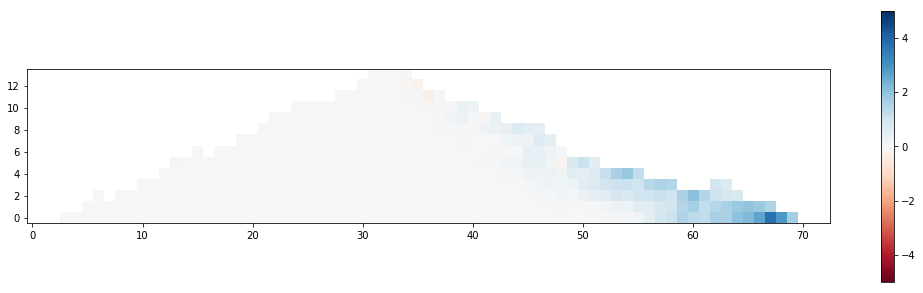

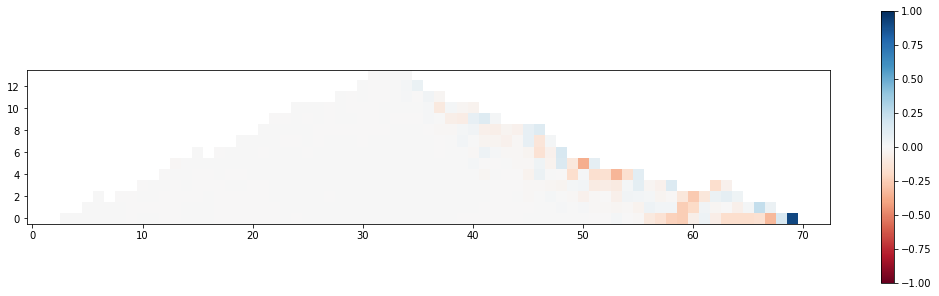

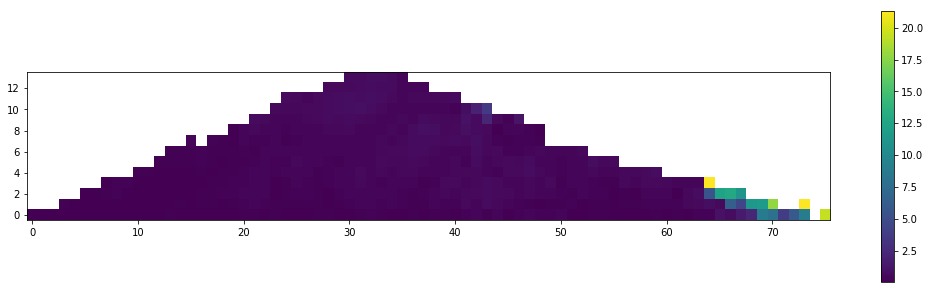

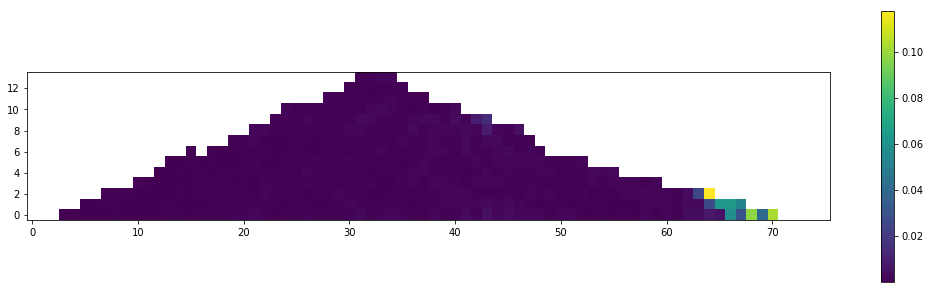

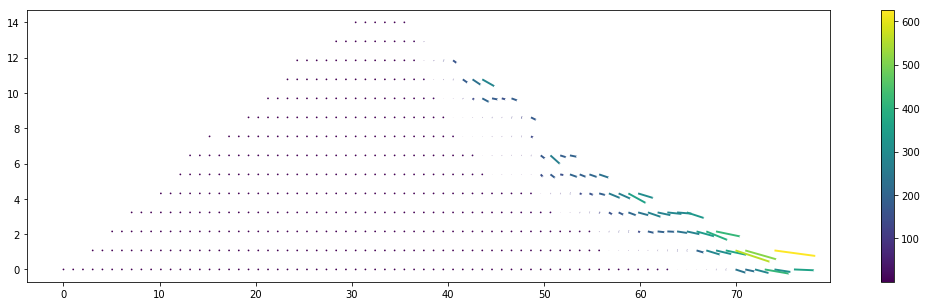

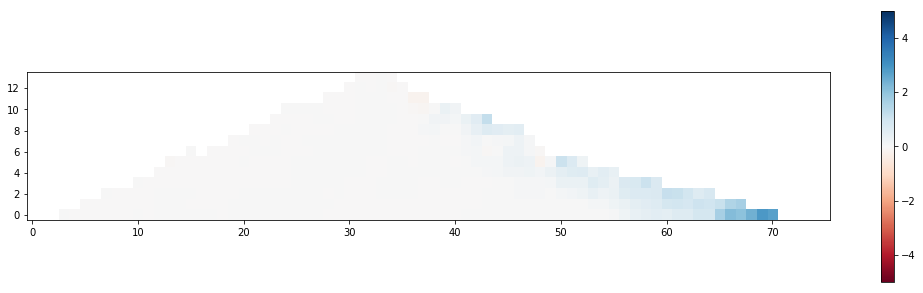

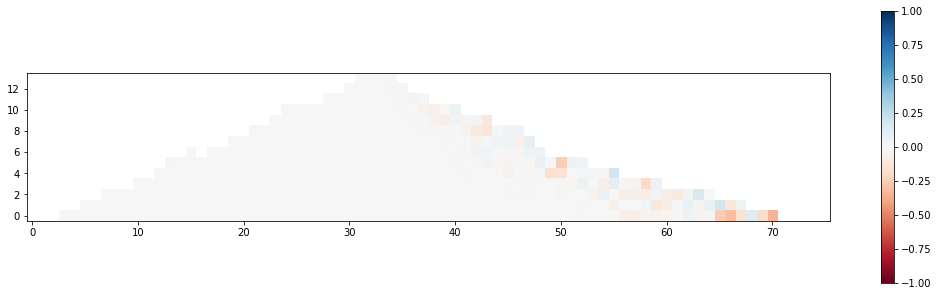

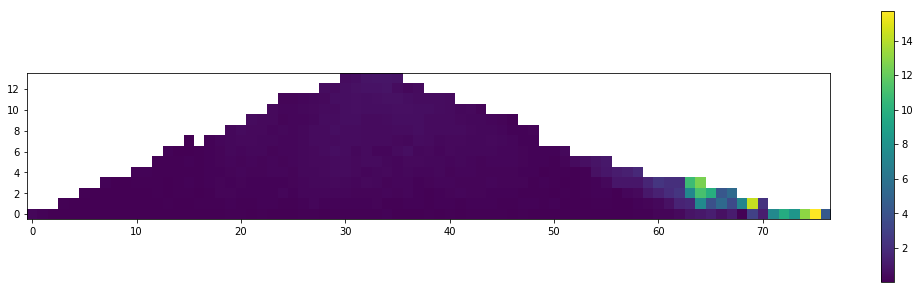

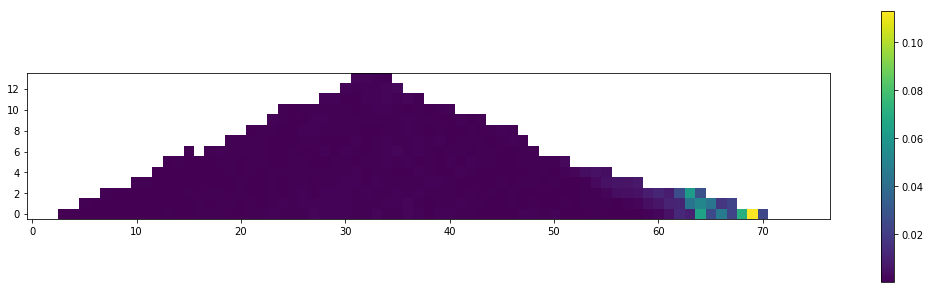

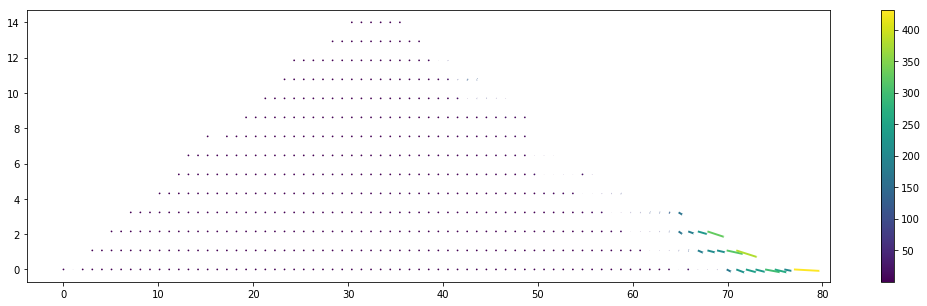

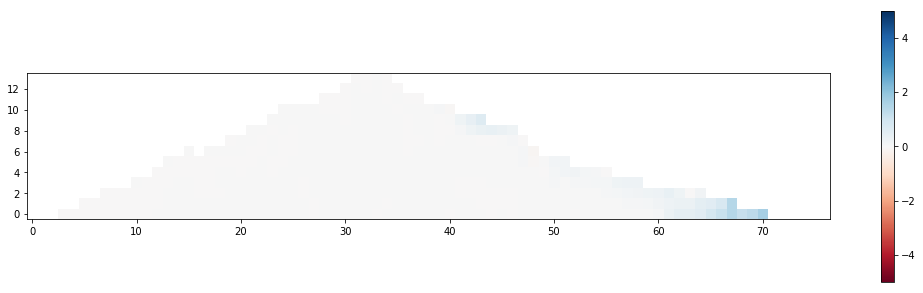

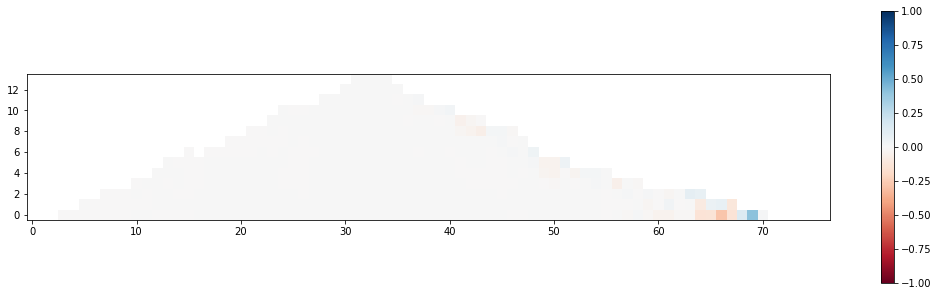

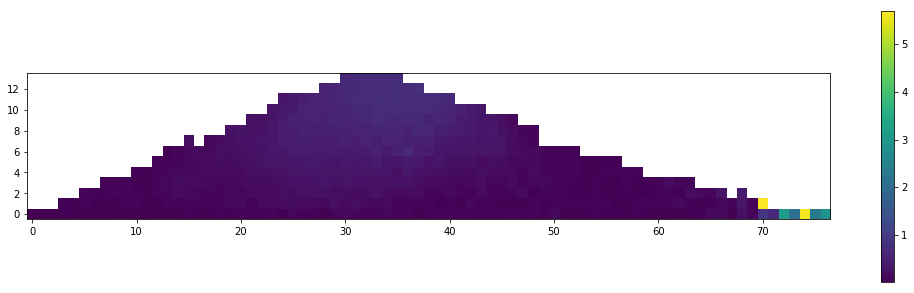

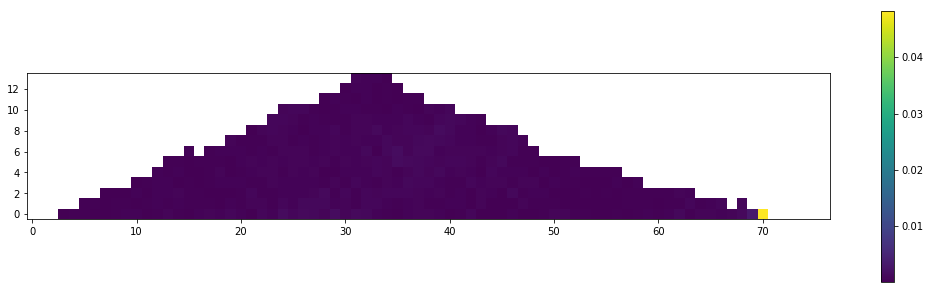

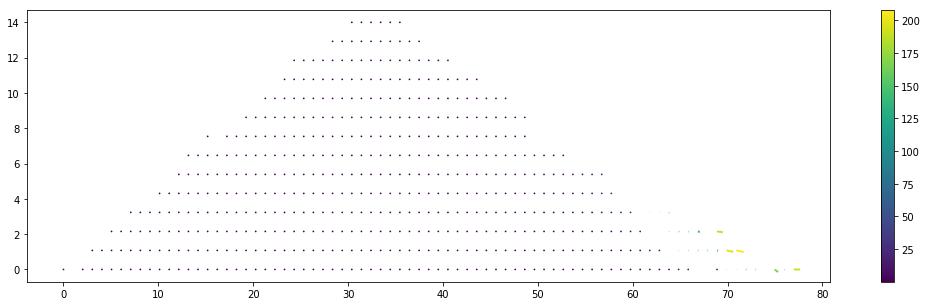

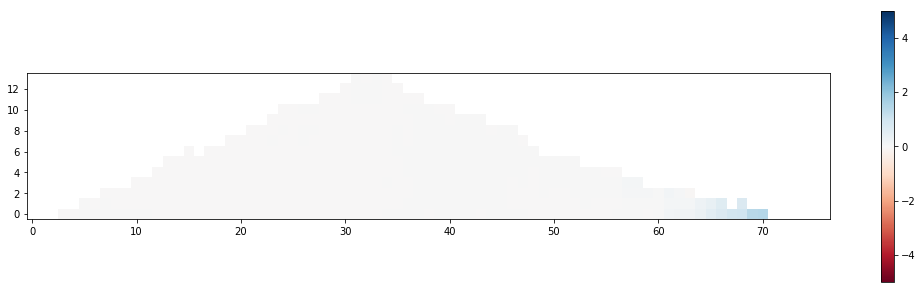

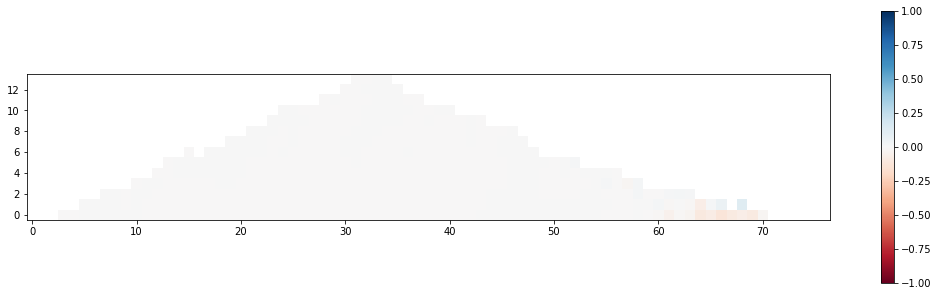

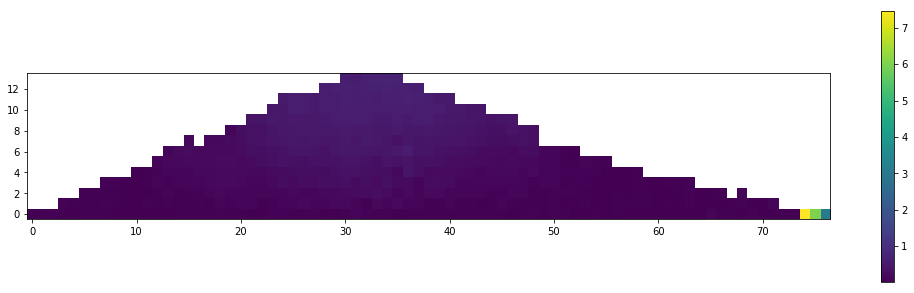

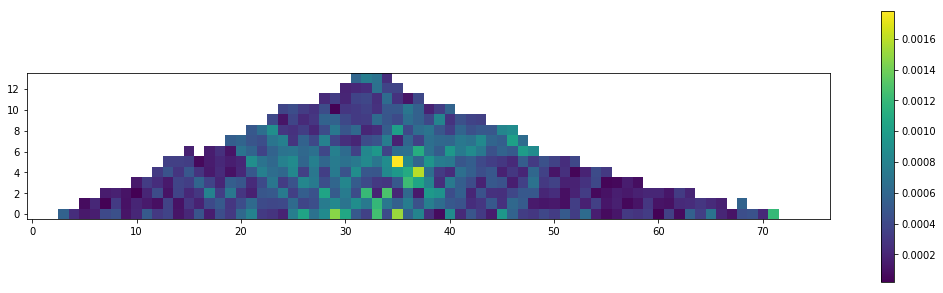

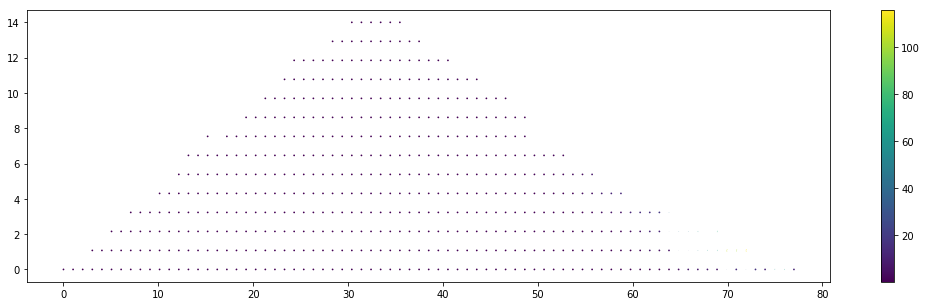

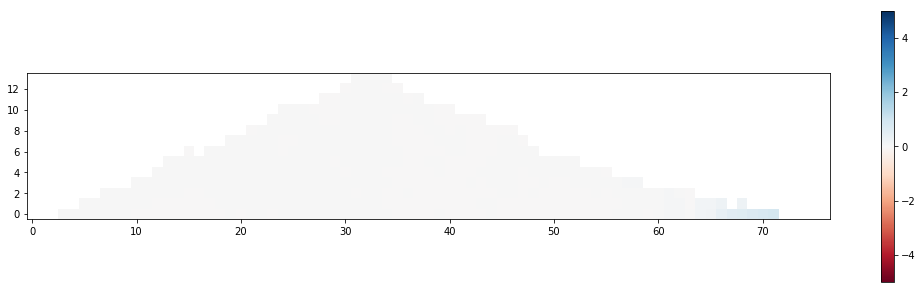

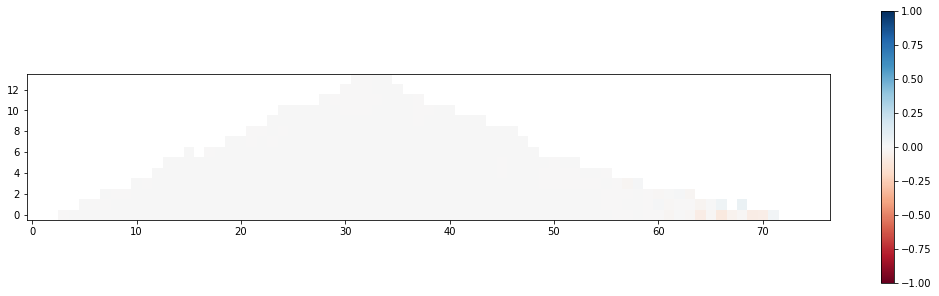

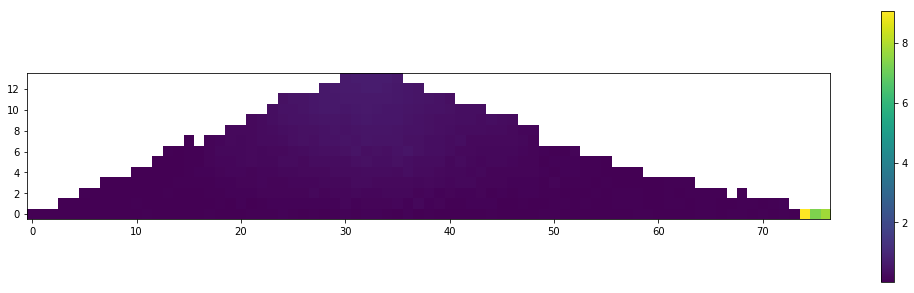

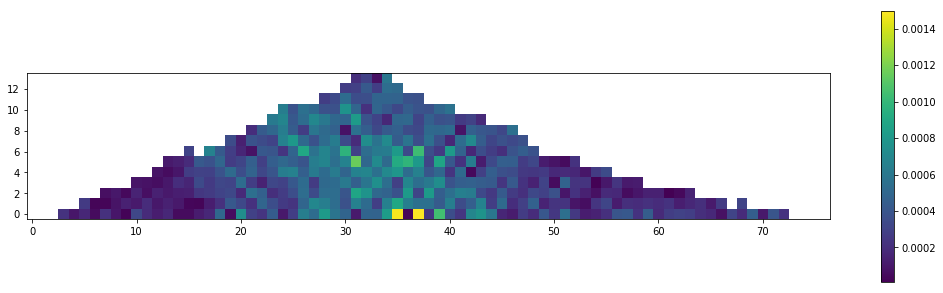

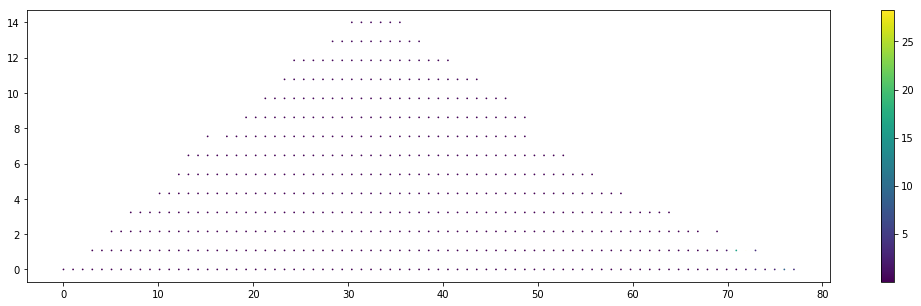

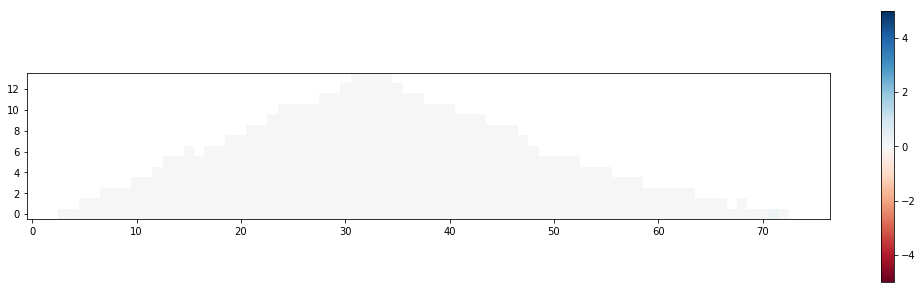

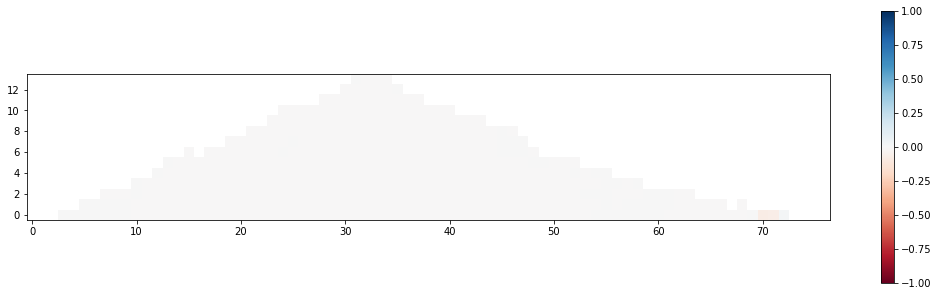

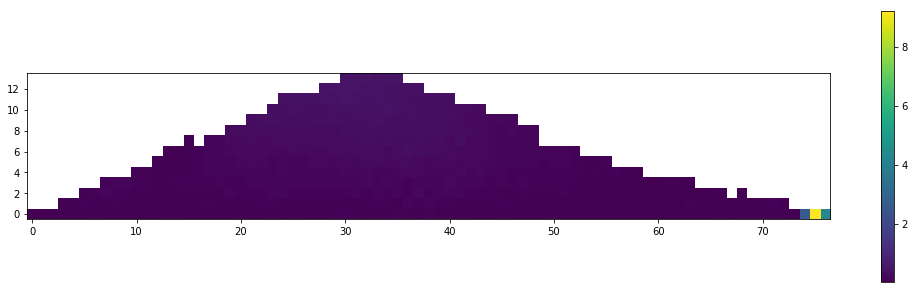

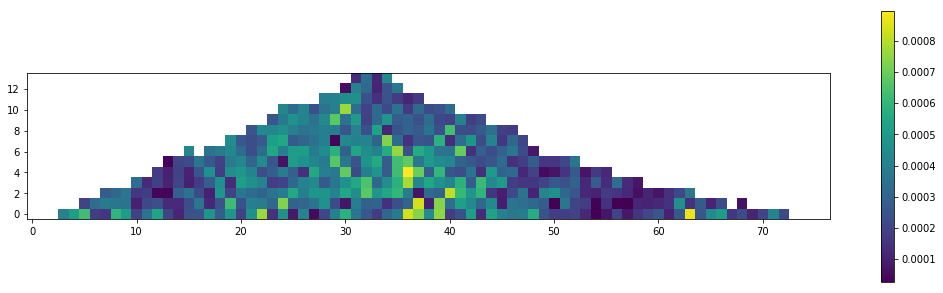

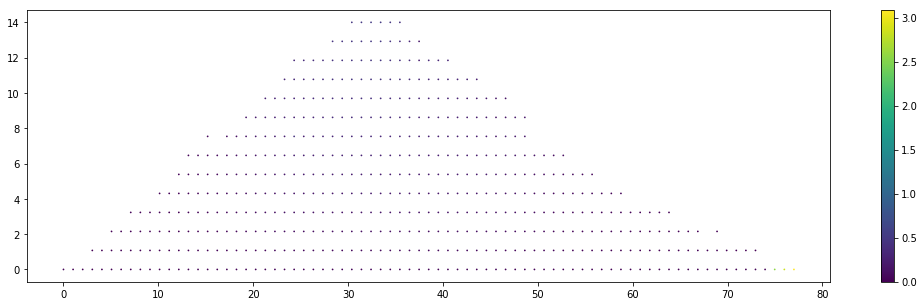

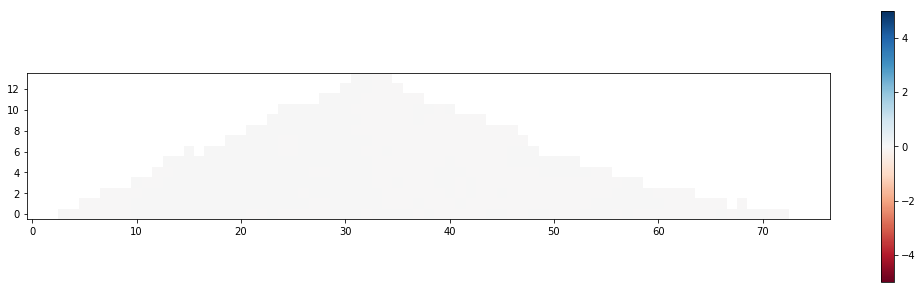

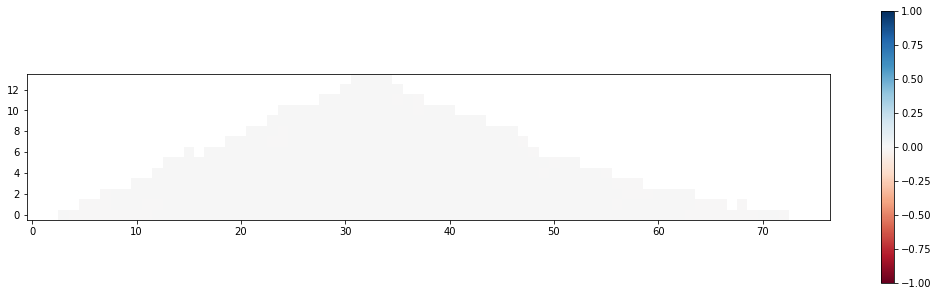

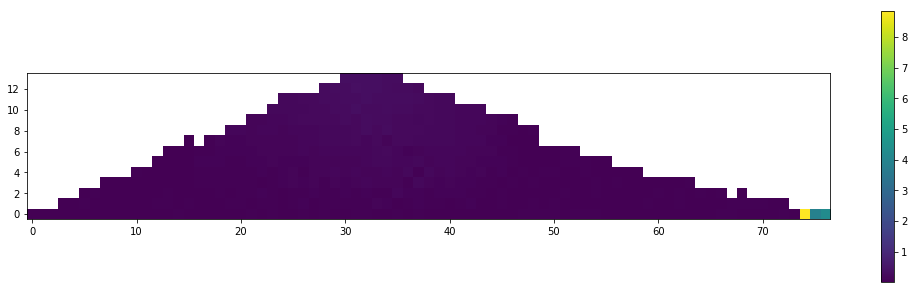

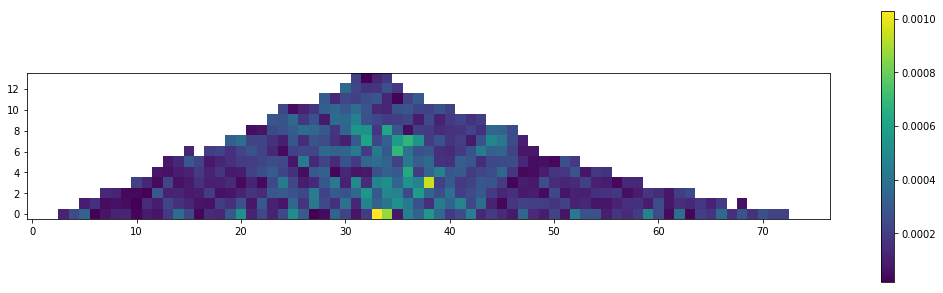

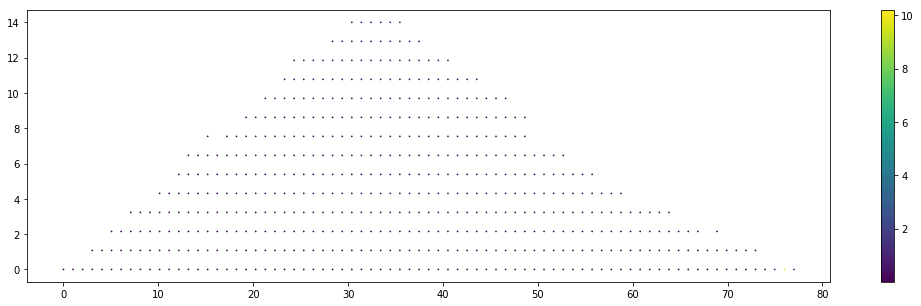

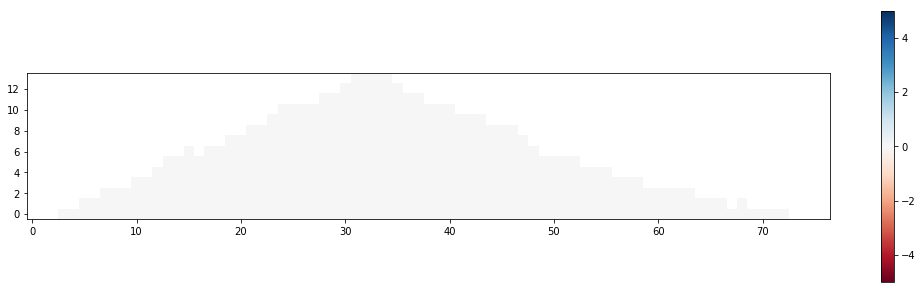

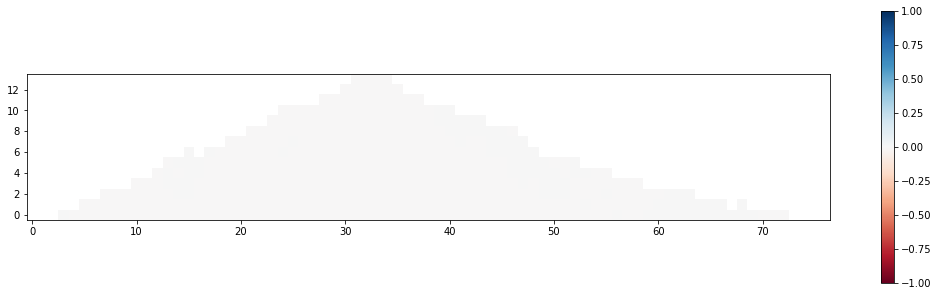

In [19]:
#postprocess control model
postProcess(results[4])

In [20]:
results[3][2].brk

[]

In [21]:
a,b = farm.dykeFromOri(pos,dip,useCost=False)

In [22]:
a,b = x

NameError: name 'x' is not defined

In [ ]:
a

In [ ]:
b